In [1]:
# Import all the libraries I need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# ignore Deprecation Warning
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers

import keras 
from keras.models import Sequential # intitialize the ANN
from keras.layers import Dense, Activation, Dropout      # create layers

import pyarrow.parquet as pq
import pyarrow as pa

np.random.seed(421)
tf.random.set_seed(421)

base_path = '/Users/ryan/neue_fische/human-protein-atlas-image-classification/data/'
embed_path = '/Users/ryan/neue_fische/human-protein-atlas-image-classification/data/embeddings_train/'


In [2]:
#get all of the labels
labels_training = pd.read_csv(base_path+'train.csv')

In [3]:
labels_training

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18
...,...,...
31067,ffed4430-bbac-11e8-b2ba-ac1f6b6435d0,21
31068,fff0a998-bbae-11e8-b2ba-ac1f6b6435d0,5
31069,fff189d8-bbab-11e8-b2ba-ac1f6b6435d0,7
31070,fffdf7e0-bbc4-11e8-b2bc-ac1f6b6435d0,25 2 21


In [4]:
class Location_in_Target(object):
    ''' Class to get a list of name of pictures which are labeled with a specific 
        location and the same number of names of pictures which labels do not 
        contain the specific location.
        ...
        Attributes:
        ----------
        location: int 
            number which define a location in a human cell
        pictures: panda.DataFrame
            list of the names of the pictures labeled with the location and 
            same number of pictures without the label
        
        Methods:
        ----------
        save_pictures(pictures, column_name):
            Saves the list of picture names in an Attribute
        get_pictures()
            Returns the list of picture names
        determine_pictures(labels)  
            Find pictures with and without the specific label and call save method
            when list is build
    '''

    def __init__(self, location): 
        '''Parameters
           ----------
           location: int 
                number which define a location in a human cell
        '''

        self.location = location
        self.pictures = pd.DataFrame()

    def save_pictures(self, pictures, column_name):
        ''' Saves the list of pictures in the attribute pictures

            Parameters
            ----------
            pictures: panda.DataFrame
                list of the names of the pictures labeled with the location and 
                same number of pictures without the label
            column_name: str
                Description of the data saved in the DataFrame used as column names 
        '''

        self.pictures[column_name] = pictures

    def get_pictures(self):
        '''Gives back the list of picture names which are labeled or not labeled
            with the given location
        '''

        return self.pictures

    def determine_pictures(self, labels):
        ''' First the names of the pictures labeled with the given location are 
            saved in a list and the method to save it in a DataFrame column is 
            called. 
            The same number of names from pictures not labeled with the location 
            are chosen randomly. The saving function is called with it again. 

            Parameters
            ----------
            labels: DataFrame with all picture names and Targets       
        '''

        pictures = [label.Id  for index, label in labels.iterrows() 
                              if str(self.location) in label.Target]
        self.save_pictures(pictures, f'pictures_with_location_{self.location}')
        #The number of pictures labeled with the given location is needed to get the 
        #same number of pictures not labeled with the location
        number_needed_pictures= len(pictures)
        pictures = [label.Id  for index, label in labels.iterrows() 
                              if str(self.location) not in label.Target]
        self.save_pictures(np.random.choice(pictures, number_needed_pictures),
                                f'pictures_without_location_{self.location}')

#### Load the full set of embeddings

In [5]:
# load embeddings (saved as parquet files), convert to pandas and get strings as strings
emb = pq.read_table(embed_path).to_pandas()
for col in ['target_id', 'image_path', 'image_name']:
    emb[col] = emb[col].str.decode('utf-8')#.fillna(df[col]) 
emb

,target_id,image_path,embedding,image_name
0,7,../data/train/4b0d7acc-bbb5-11e8-b2ba-ac1f6b64...,"[-0.14782768, -0.19346946, 0.029495712, -0.114...",4b0d7acc-bbb5-11e8-b2ba-ac1f6b6435d0
1,5 0,../data/train/4b0e4648-bbc2-11e8-b2bb-ac1f6b64...,"[-0.11768038, 0.108380914, -0.07158355, -0.051...",4b0e4648-bbc2-11e8-b2bb-ac1f6b6435d0
2,23,../data/train/4b0fe352-bbbf-11e8-b2ba-ac1f6b64...,"[-0.14264518, -0.14894637, 0.015262008, -0.138...",4b0fe352-bbbf-11e8-b2ba-ac1f6b6435d0
3,2,../data/train/4b1164e4-bbaf-11e8-b2ba-ac1f6b64...,"[-0.14977421, -0.12706101, -0.17702478, -0.087...",4b1164e4-bbaf-11e8-b2ba-ac1f6b6435d0
4,25,../data/train/4b120c9e-bbb1-11e8-b2ba-ac1f6b64...,"[-0.15020615, -0.008659467, -0.14262204, -0.04...",4b120c9e-bbb1-11e8-b2ba-ac1f6b6435d0
...,...,...,...,...
31067,7,../data/train/9d04d730-bbb5-11e8-b2ba-ac1f6b64...,"[-0.095827445, -0.14014255, -0.1306586, -0.081...",9d04d730-bbb5-11e8-b2ba-ac1f6b6435d0
31068,4,../data/train/9d09c7e0-bb9c-11e8-b2b9-ac1f6b64...,"[-0.109680824, -0.07402489, -0.08704822, -0.08...",9d09c7e0-bb9c-11e8-b2b9-ac1f6b6435d0
31069,0,../data/train/9d0a7012-bbc6-11e8-b2bc-ac1f6b64...,"[-0.14760047, -0.105946906, 0.17695697, -0.130...",9d0a7012-bbc6-11e8-b2bc-ac1f6b6435d0
31070,25 0,../data/train/9d10ecec-bba0-11e8-b2b9-ac1f6b64...,"[-0.12235144, -0.12698074, -0.052961998, -0.10...",9d10ecec-bba0-11e8-b2b9-ac1f6b6435d0


#### Test the class with Mitochondria labeled with a 23
- create a balanced subset of images that have mitochondria or not

In [6]:
mitochondria_pictures = Location_in_Target(location = 23)
mitochondria_pictures.determine_pictures(labels_training)
#Dataframe with filenames of pictures which have mitochondria
df_mit = mitochondria_pictures.get_pictures().pictures_with_location_23
#Dataframe with filenames of pictures which have no mitochondria
df_no_mit = mitochondria_pictures.get_pictures().pictures_without_location_23

In [7]:
# use join to pull out the embeddings of the mitochondria subset
# first get the mitochondria and set target = 1
emb_mit = emb.merge(df_mit.rename("image_name").to_frame(), how="right", on="image_name")
emb_mit["target_id"] = 1
# now the others, target = 0
emb_no_mit = emb.merge(df_no_mit.rename("image_name").to_frame(), how="right", on="image_name")
emb_no_mit["target_id"] = 0
# now combine them into one table and shuffle
df_emb_mit = pd.concat([emb_mit, emb_no_mit]).reset_index().drop('index', axis=1)
df_emb_mit = shuffle(df_emb_mit, random_state=42)
df_emb_mit

,target_id,image_path,embedding,image_name
1044,1,../data/train/5b4b5490-bbbf-11e8-b2ba-ac1f6b64...,"[-0.13118611, -0.1529398, -0.1603711, -0.06997...",5b4b5490-bbbf-11e8-b2ba-ac1f6b6435d0
199,1,../data/train/127e7a78-bbae-11e8-b2ba-ac1f6b64...,"[-0.09286587, -0.1696373, -0.041827142, -0.098...",127e7a78-bbae-11e8-b2ba-ac1f6b6435d0
3203,0,../data/train/77bf620e-bbc6-11e8-b2bc-ac1f6b64...,"[-0.14101768, -0.20399186, -0.07108468, -0.041...",77bf620e-bbc6-11e8-b2bc-ac1f6b6435d0
2721,1,../data/train/ea2d2528-bbc7-11e8-b2bc-ac1f6b64...,"[-0.14769897, -0.18474159, -0.0681372, -0.0949...",ea2d2528-bbc7-11e8-b2bc-ac1f6b6435d0
3195,0,../data/train/d2788544-bb9a-11e8-b2b9-ac1f6b64...,"[-0.112978876, -0.16276217, -0.19172694, -0.10...",d2788544-bb9a-11e8-b2b9-ac1f6b6435d0
...,...,...,...,...
3772,0,../data/train/2ac38132-bbae-11e8-b2ba-ac1f6b64...,"[-0.1174876, -0.16022941, -0.10193683, -0.1116...",2ac38132-bbae-11e8-b2ba-ac1f6b6435d0
5191,0,../data/train/a0827e1c-bbbf-11e8-b2bb-ac1f6b64...,"[-0.10753478, 0.06106223, -0.14162362, -0.0953...",a0827e1c-bbbf-11e8-b2bb-ac1f6b6435d0
5226,0,../data/train/f3c62328-bbb8-11e8-b2ba-ac1f6b64...,"[-0.13293919, -0.13260102, -0.16280034, -0.097...",f3c62328-bbb8-11e8-b2ba-ac1f6b6435d0
5390,0,../data/train/1aeffbcc-bbaa-11e8-b2ba-ac1f6b64...,"[-0.14555976, 0.081755675, -0.0934186, -0.0732...",1aeffbcc-bbaa-11e8-b2ba-ac1f6b6435d0


In [8]:
# put the features (embeddings) in one dataframe
df_feats = pd.DataFrame(list(map(np.ravel, df_emb_mit.embedding)))
df_feats

,0,1,2,3,4,5,6,7,8,9,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,-0.131186,-0.152940,-0.160371,-0.069971,-0.219888,0.384113,-0.121298,-0.074953,-0.093091,-0.139779,...,-0.035331,-0.193512,-0.176112,0.005173,-0.125174,0.211034,-0.042802,-0.142685,-0.143950,0.366367
1,-0.092866,-0.169637,-0.041827,-0.098645,-0.121831,0.281739,-0.152558,-0.060075,-0.058997,-0.106009,...,-0.020068,-0.185867,-0.045578,1.144489,-0.118960,1.328773,-0.030518,-0.097414,-0.158296,0.368325
2,-0.141018,-0.203992,-0.071085,-0.041876,-0.128638,-0.139662,-0.064844,-0.089772,-0.117533,-0.054310,...,-0.114371,-0.169269,-0.135751,-0.047908,-0.113111,-0.163869,-0.019703,-0.064418,-0.054484,0.129067
3,-0.147699,-0.184742,-0.068137,-0.094991,-0.190855,0.285059,-0.093948,-0.090707,0.023514,-0.143357,...,-0.079538,-0.178056,-0.046342,0.223968,-0.149693,0.649486,-0.033663,-0.146221,-0.141256,0.893519
4,-0.112979,-0.162762,-0.191727,-0.100751,-0.151975,0.483723,-0.100306,-0.062937,0.173433,-0.066092,...,-0.018409,-0.178215,-0.068899,0.427814,-0.125512,0.380474,-0.029350,-0.088946,-0.157720,0.328639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5925,-0.117488,-0.160229,-0.101937,-0.111626,-0.157648,0.093318,-0.043965,-0.129352,-0.147930,-0.067994,...,-0.157488,-0.205593,0.216010,0.111926,-0.142108,0.125272,-0.030851,-0.064595,-0.111929,0.288320
5926,-0.107535,0.061062,-0.141624,-0.095322,-0.104741,0.655244,0.003111,-0.066606,0.462405,-0.147635,...,0.380892,-0.154877,0.055392,0.577843,-0.113244,0.657192,-0.043185,-0.037336,-0.164773,0.607521
5927,-0.132939,-0.132601,-0.162800,-0.097778,-0.130278,0.101235,-0.103981,-0.081868,-0.104901,-0.118869,...,-0.088138,-0.178233,-0.080511,0.838986,-0.006833,0.972202,-0.027576,-0.125058,-0.161686,-0.044101
5928,-0.145560,0.081756,-0.093419,-0.073278,0.192415,0.272839,-0.093826,-0.117621,0.127328,-0.083527,...,-0.071539,-0.154958,-0.057790,0.382123,0.057597,0.475719,-0.052168,-0.135477,-0.154502,0.236559


In [9]:
# get the targets, one hot encode and put into a dataframe

# courtesy of https://www.kaggle.com/code/allunia/protein-atlas-exploration-and-baseline
label_names = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

reverse_train_labels = dict((v,k) for k,v in label_names.items())

# target dataframe
targets = df_emb_mit['target_id']
targets

1044    1
199     1
3203    0
2721    1
3195    0
       ..
3772    0
5191    0
5226    0
5390    0
860     1
Name: target_id, Length: 5930, dtype: int64

### Notes:
- data may still need to be scaled
- also not uniformly distributed --- log?

### Split into train/test and transform/standardize

In [10]:
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(df_feats, targets)

#sns.pairplot(pd.concat([X_train,y_train],axis=1).iloc[:,-5:], hue="target_id");

In [11]:
y_train.isna().sum(), X_train.isna().sum().sum()

(0, 0)

In [12]:
# first, try to get normally distributed using QuantileTransformer
transformer = QuantileTransformer()
X_train= transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

# now with norm dist, apply StandardScaler
scaler = MinMaxScaler()# StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



In [13]:
X_train.shape, y_train.shape

((4447, 1280), (4447,))

In [14]:
# check to see what transform/standardize are doing to the data
#sns.pairplot(pd.DataFrame(X_train).join(pd.DataFrame({'target_id': y_train})).iloc[:,-5:], hue="target_id");

# !!! join may not be working, since nan created in target_id??

In [15]:
np.isnan(X_train).sum().sum()

0

In [16]:
y_train.isna().sum(), np.isnan(X_train).sum().sum()
#y_train.isna().sum(),X_train.isna().sum().sum()


(0, 0)

In [17]:
#run the model
#take setup form exercise 3 
# Initialising the NN
# adding regularization and dropout to reduce overfitting
model = Sequential()

# layers
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', kernel_regularizer=regularizers.l2(0.000001), 
            input_dim = 1280))
model.add(Dropout(0.25))
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', kernel_regularizer=regularizers.l2(0.000001)))
model.add(Dropout(0.25))
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', kernel_regularizer=regularizers.l2(0.000001)))
model.add(Dropout(0.25))
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', kernel_regularizer=regularizers.l2(0.000001)))
model.add(Dropout(0.25))
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', kernel_regularizer=regularizers.l2(0.000001)))
model.add(Dropout(0.25))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-07-03 18:26:02.574163: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-03 18:26:02.574302: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [18]:
plot_model(
    model, to_file='model.png', show_shapes=True, 
    show_layer_names=True, dpi=96
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [19]:
len(X_train)

4447

In [20]:
# Train the ANN
# training = model.fit(X_train, y_train, batch_size = 24, validation_split=0.2, epochs = 100)
#-> overfits

# Define dictionary to store results
training_history = {}

# Define number of epochs and learning rate decay
N_TRAIN = len(X_train)
EPOCHS = 2000 # 200
BATCH_SIZE = 1000 # 48
STEPS_PER_EPOCH = N_TRAIN // BATCH_SIZE
# hyperbolically decrease the learning rate to 1/2 of base rate after 1000 epochs and so on
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*1000, # 10
    decay_rate=1,
    staircase=False)


# Define optimizer used for modelling
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, name='Adam')

from keras.optimizers import SGD
# optimizer = SGD(lr=0.00001)

In [21]:
# Compiling the ANN
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                40992     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                1

In [22]:
with tf.device('/cpu:0'):
    training = model.fit(X_train,
                        y_train,
                        validation_split=0.2,
                        verbose=1,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS)

Epoch 1/2000


2022-07-03 18:26:02.939518: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/4 [======>.......................] - ETA: 1s - loss: 0.6932 - accuracy: 0.5230

2022-07-03 18:26:03.441457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 45ms/step - loss: 0.6932 - accuracy: 0.4976 - val_loss: 0.6932 - val_accuracy: 0.4921
Epoch 2/2000
4/4 [==============================] - 0s 14ms/step - loss: 0.6932 - accuracy: 0.5077 - val_loss: 0.6932 - val_accuracy: 0.4921
Epoch 3/2000
4/4 [==============================] - 0s 12ms/step - loss: 0.6932 - accuracy: 0.5060 - val_loss: 0.6932 - val_accuracy: 0.4921
Epoch 4/2000
4/4 [==============================] - 0s 11ms/step - loss: 0.6932 - accuracy: 0.5060 - val_loss: 0.6932 - val_accuracy: 0.4921
Epoch 5/2000
1/4 [======>.......................] - ETA: 0s - loss: 0.6933 - accuracy: 0.4840

2022-07-03 18:26:03.677093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 12ms/step - loss: 0.6931 - accuracy: 0.5060 - val_loss: 0.6932 - val_accuracy: 0.4921
Epoch 6/2000
4/4 [==============================] - 0s 12ms/step - loss: 0.6931 - accuracy: 0.5060 - val_loss: 0.6933 - val_accuracy: 0.4921
Epoch 7/2000
4/4 [==============================] - 0s 12ms/step - loss: 0.6931 - accuracy: 0.5060 - val_loss: 0.6933 - val_accuracy: 0.4921
Epoch 8/2000
4/4 [==============================] - 0s 12ms/step - loss: 0.6931 - accuracy: 0.5060 - val_loss: 0.6933 - val_accuracy: 0.4921
Epoch 9/2000
4/4 [==============================] - 0s 11ms/step - loss: 0.6931 - accuracy: 0.5060 - val_loss: 0.6933 - val_accuracy: 0.4921
Epoch 10/2000
4/4 [==============================] - 0s 11ms/step - loss: 0.6931 - accuracy: 0.5060 - val_loss: 0.6933 - val_accuracy: 0.4921
Epoch 11/2000
4/4 [==============================] - 0s 12ms/step - loss: 0.6931 - accuracy: 0.5060 - val_loss: 0.6933 - val_accuracy: 0.4921
Epoch 12/2000
4/4 [=====

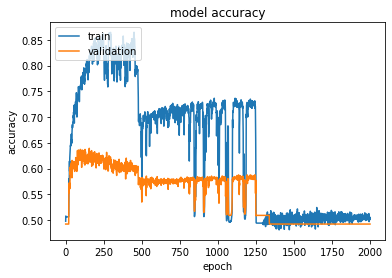

In [23]:
# summarize history for accuracy
plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### !!!! turning on regularizers seems to stall model, results don't improve just stuck under 0.5 for both train and validate. Running on test data shows it is only able to predict 1, never guesses 0


47/47 [==============================] - 0s 2ms/step


2022-07-03 18:27:38.932046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


0.49

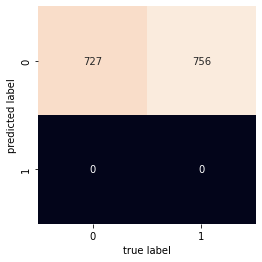

In [24]:
y_pred = model.predict(X_test)

# Plotting the confusing matrix
mat = confusion_matrix(y_test, y_pred.round())
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

accuracy_score(y_test, y_pred.round()).round(2)